In [12]:
import os
import numpy as np
import open3d as o3d

In [ ]:
def get_stats_point(data_path, output_path):
    import os
    import numpy as np
    import open3d as o3d

    # list all subfolders under data_path
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        convert_path = os.path.join(output_path, folder, "velodyne")
        print(f"\nProcessing folder: {folder}")

        # skip if it's not a directory
        if not os.path.isdir(folder_path):
            continue

        get_percentage = []
        for file in os.listdir(folder_path):
            if not file.lower().endswith('.ply'):
                continue

            # read original point cloud
            orig_file = os.path.join(folder_path, file)
            orig_pcd = o3d.io.read_point_cloud(orig_file)
            orig_points = np.asarray(orig_pcd.points)
            
            # build path to converted file in output/velodyne
            base = os.path.splitext(file)[0]
            conv_file = os.path.join(convert_path, f"{base}.npy")
            
            if os.path.exists(conv_file):
                conv_points = np.load(conv_file)
                # Calculate percentage of points preserved
                percentage = len(conv_points) / len(orig_points) * 100
                get_percentage.append(percentage)
            #     print(f"File: {file}, Points preserved: {percentage:.2f}%")
            # else:
            #     print(f"Warning: Converted file not found for {file}")

        if get_percentage:
            avg_percentage = sum(get_percentage) / len(get_percentage)
            print(f"\nFolder {folder} statistics:")
            print(f"Average points preserved: {avg_percentage:.2f}%")

    # print(ply_files) 
get_stats('data', 'output')


Processing folder: 0

Folder 0 statistics:
Average points preserved: 84.26%

Processing folder: 1

Folder 1 statistics:
Average points preserved: 66.78%

Processing folder: 2

Folder 2 statistics:
Average points preserved: 64.14%

Processing folder: 3

Folder 3 statistics:
Average points preserved: 72.89%

Processing folder: 4

Folder 4 statistics:
Average points preserved: 63.90%

Processing folder: 5

Folder 5 statistics:
Average points preserved: 78.38%

Processing folder: 6

Folder 6 statistics:
Average points preserved: 67.02%

Processing folder: 7

Folder 7 statistics:
Average points preserved: 60.52%


# Get Accuracy

In [3]:
import numpy as np

# Get Len
folder_num = 0
file_num = 5
orginal_path = f'data/{folder_num}/{file_num}_labels.npy'
input_path =f'output/{folder_num}/labels/{file_num}.npy'
out_path = f'result/{folder_num}/predictions/{file_num}.npy'

# load file 
org = np.load(orginal_path).ravel()
inp = np.load(input_path).ravel()
oup = np.load(out_path).ravel()

print(org.shape)
print(np.unique(org))
print(inp.shape)
print(np.unique(inp))
print(oup.shape)
print(np.unique(oup))

(2072,)
[0 1 2]
(1669,)
[0 1 2]
(1669,)
[1 2]


In [3]:
import os
import numpy as np
from collections import defaultdict

# --- USER CONFIG ---
# folder_num
LABEL_DIR = 'output/0/labels'
PRED_DIR  = 'result/0/predictions'
NUM_CLASSES = 3  # e.g. number of semantic classes
# --- UTILITY FUNCTIONS ---
def load_labels(path):
    """Load your ground-truth label file.
    Adjust this if your labels are in .label, .bin, etc."""
    if path.endswith('.npy'):
        return np.load(path)
    else:
        # example for KITTI .label files (uint32)
        return np.fromfile(path, dtype=np.uint32)

# --- MAIN IoU COMPUTATION ---
# initialize counts
intersection = np.zeros(NUM_CLASSES, dtype=np.int64)
union        = np.zeros(NUM_CLASSES, dtype=np.int64)

# gather and sort files to align GT vs prediction
gt_files   = sorted(os.listdir(LABEL_DIR))
pred_files = sorted(os.listdir(PRED_DIR))

assert len(gt_files) == len(pred_files), "Mismatch in number of files!"

for gt_fname, pred_fname in zip(gt_files, pred_files):
    gt_path   = os.path.join(LABEL_DIR, gt_fname)
    pred_path = os.path.join(PRED_DIR,  pred_fname)
    
    gt   = load_labels(gt_path).ravel()
    pred = np.load(pred_path).ravel()
    assert gt.shape == pred.shape, f"Shape mismatch for {gt_fname}"
    
    for c in range(NUM_CLASSES):
        gt_c   = (gt   == c)
        pred_c = (pred == c)
        intersection[c] += np.sum(gt_c & pred_c)
        union[c]        += np.sum(gt_c | pred_c)

# compute per-class IoU, handling classes with zero union
ious = []
for c in range(NUM_CLASSES):
    if union[c] == 0:
        ious.append(float('nan'))  # no pixels of this class in GT & pred
    else:
        ious.append(intersection[c] / union[c])
    print(ious[c])

# report
for c, iou in enumerate(ious):
    print(f"Class {c:2d}: IoU = {iou:.4f}")
    
valid_ious = [iou for iou in ious if not np.isnan(iou)]
miou = np.mean(valid_ious)
print(f"\nmIoU over {len(valid_ious)} classes: {miou:.4f}")


0.0
0.47610422300457506
0.27074986545476293
Class  0: IoU = 0.0000
Class  1: IoU = 0.4761
Class  2: IoU = 0.2707

mIoU over 3 classes: 0.2490


In [2]:
import os
import numpy as np

# --- USER CONFIG ---
LABEL_DIR   = 'output/0/labels'
PRED_DIR    = 'result/0/predictions'
NUM_CLASSES = 3  # adjust to your number of classes

# --- UTILITY FUNCTION ---
def load_labels(path):
    """Load your ground-truth label file."""
    if path.endswith('.npy'):
        return np.load(path)
    else:
        # example for KITTI .label files (uint32)
        return np.fromfile(path, dtype=np.uint32)

# --- MAIN IoU COMPUTATION ---
# initialize counts
intersection = np.zeros(NUM_CLASSES, dtype=np.int64)
union        = np.zeros(NUM_CLASSES, dtype=np.int64)

# gather and sort files to align GT vs prediction
gt_files   = sorted(os.listdir(LABEL_DIR))
pred_files = sorted(os.listdir(PRED_DIR))
assert len(gt_files) == len(pred_files), "Mismatch in number of files!"

for gt_fname, pred_fname in zip(gt_files, pred_files):
    gt_path   = os.path.join(LABEL_DIR,   gt_fname)
    pred_path = os.path.join(PRED_DIR,    pred_fname)
    
    gt   = load_labels(gt_path).ravel()
    pred = np.load(pred_path).ravel()
    assert gt.shape == pred.shape, f"Shape mismatch for {gt_fname}"
    
    for c in range(NUM_CLASSES):
        gt_c   = (gt   == c)
        pred_c = (pred == c)
        # use logical_and / logical_or for clarity and safety
        intersection[c] += np.sum(np.logical_and(gt_c, pred_c))
        union[c]        += np.sum(np.logical_or(gt_c, pred_c))

# compute per-class IoU, handling classes with zero union
ious = []
for c in range(NUM_CLASSES):
    if union[c] == 0:
        ious.append(float('nan'))  # no pixels of this class in GT & pred
    else:
        ious.append(intersection[c] / union[c])
    print(f"Raw IoU class {c}: {ious[c]}")

# report results
for c, iou in enumerate(ious):
    print(f"Class {c:2d}: IoU = {iou:.4f}")

valid_ious = [iou for iou in ious if not np.isnan(iou)]
miou = np.mean(valid_ious) if valid_ious else float('nan')
print(f"\nmIoU over {len(valid_ious)} classes: {miou:.4f}")


Raw IoU class 0: 0.0
Raw IoU class 1: 0.47610422300457506
Raw IoU class 2: 0.27074986545476293
Class  0: IoU = 0.0000
Class  1: IoU = 0.4761
Class  2: IoU = 0.2707

mIoU over 3 classes: 0.2490



Mean image-level mIoU over 145 files: 0.4323
Min miou:0.20534257865929517
Max miou:0.7595972042234072


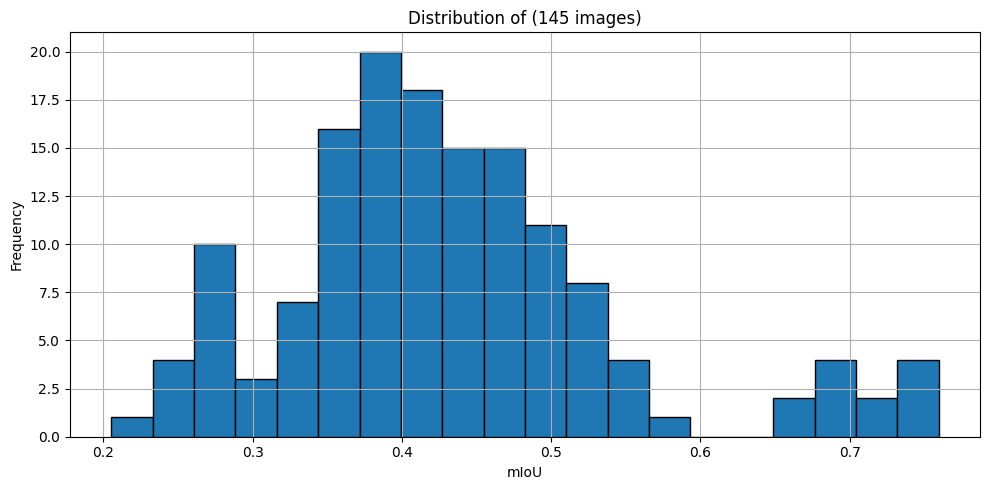

In [ ]:
import os
import numpy as np

# --- USER CONFIG ---
file_num = 1
LABEL_DIR   = f'output/{file_num}/labels'
PRED_DIR    = f'result/{file_num}/predictions'
NUM_CLASSES = 3  # adjust to your number of classes

# --- UTILITY FUNCTION ---
def load_labels(path):
    if path.endswith('.npy'):
        return np.load(path)
    else:
        return np.fromfile(path, dtype=np.uint32)

# gather and sort files
gt_files   = sorted(os.listdir(LABEL_DIR))
pred_files = sorted(os.listdir(PRED_DIR))
# assert len(gt_files) == len(pred_files), "Mismatch in number of files!"

per_image_mious = []

for gt_fname, pred_fname in zip(gt_files, pred_files):
    gt   = np.load(os.path.join(LABEL_DIR, gt_fname)).ravel()
    pred = np.load(os.path.join(PRED_DIR,  pred_fname)).ravel()
    assert gt.shape == pred.shape, f"Shape mismatch for {gt_fname}, {pred_fname}"
    
    # compute IoU per class for this image
    ious = []
    for c in range(NUM_CLASSES):
        gt_c   = (gt   == c)
        pred_c = (pred == c)
        inter = np.sum(np.logical_and(gt_c, pred_c))
        uni   = np.sum(np.logical_or (gt_c, pred_c))
        if uni == 0:
            ious.append(np.nan)
        else:
            ious.append(inter / uni)
    
    # average over classes (ignoring NaNs)
    valid = [iou for iou in ious if not np.isnan(iou)]
    miou_i = np.mean(valid) if valid else np.nan
    per_image_mious.append(miou_i)

# finally, mean over all images
mean_miou = np.nanmean(per_image_mious)
print(f"\nMean image-level mIoU over {len(per_image_mious)} files: {mean_miou:.4f}")
print(f"Min miou:{np.nanmin(per_image_mious)}")
print(f"Max miou:{np.nanmax(per_image_mious)}")

# import matplotlib.pyplot as plt

# # --- PLOTTING ---
# plt.figure(figsize=(10, 5))
# plt.hist(per_image_mious, bins=20, edgecolor='black')
# plt.title(f'Distribution of ({len(per_image_mious)} images)')
# plt.xlabel('mIoU')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.tight_layout()
# plt.show()




In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- USER CONFIG ---
NUM_CLASSES = 3  # adjust to your number of classes
START_NUM = 0
END_NUM   = 7

# --- STORAGE ---
all_per_image_mious = []
summary = []

# --- UTILITY FUNCTION ---
def load_labels(path):
    if path.endswith('.npy'):
        return np.load(path)
    else:
        return np.fromfile(path, dtype=np.uint32)

# --- LOOP THROUGH ALL FILE_NUM FOLDERS ---
for file_num in range(START_NUM, END_NUM + 1):
    LABEL_DIR = f'output/{file_num}/labels'
    PRED_DIR  = f'result/{file_num}/predictions'

    if not os.path.exists(LABEL_DIR) or not os.path.exists(PRED_DIR):
        print(f"Skipping file_num={file_num} due to missing folder(s).")
        continue

    gt_files   = sorted(os.listdir(LABEL_DIR))
    pred_files = sorted(os.listdir(PRED_DIR))

    per_image_mious = []

    for gt_fname, pred_fname in zip(gt_files, pred_files):
        gt   = load_labels(os.path.join(LABEL_DIR, gt_fname)).ravel()
        pred = load_labels(os.path.join(PRED_DIR,  pred_fname)).ravel()
        assert gt.shape == pred.shape, f"Shape mismatch: {gt_fname}, {pred_fname}"

        # compute IoU per class
        ious = []
        for c in range(NUM_CLASSES):
            gt_c = (gt == c)
            pred_c = (pred == c)
            inter = np.sum(np.logical_and(gt_c, pred_c))
            uni   = np.sum(np.logical_or(gt_c, pred_c))
            ious.append(np.nan if uni == 0 else inter / uni)

        valid = [iou for iou in ious if not np.isnan(iou)]
        miou_i = np.mean(valid) if valid else np.nan
        per_image_mious.append(miou_i)

    # store summary
    mean_miou = np.nanmean(per_image_mious)
    min_miou  = np.nanmin(per_image_mious)
    max_miou  = np.nanmax(per_image_mious)
    print(len(per_image_mious))
    print(f"[file_num={file_num}] Mean: {mean_miou:.4f}, Min: {min_miou:.4f}, Max: {max_miou:.4f}")
    summary.append((file_num, mean_miou, min_miou, max_miou))
    all_per_image_mious.append(per_image_mious)

# final mean
overall_mean = np.nanmean([np.nanmean(mious) for mious in all_per_image_mious])
print(f"\nOverall mean mIoU across all file_nums: {overall_mean:.4f}")


30
[file_num=0] Mean: 0.3729, Min: 0.2866, Max: 1.0000
145
[file_num=1] Mean: 0.4323, Min: 0.2053, Max: 0.7596
1363
[file_num=2] Mean: 0.5299, Min: 0.2203, Max: 0.9892
436
[file_num=3] Mean: 0.5003, Min: 0.2233, Max: 1.0000
291
[file_num=4] Mean: 0.3415, Min: 0.1349, Max: 0.6051
44
[file_num=5] Mean: 0.4643, Min: 0.2734, Max: 1.0000
1170
[file_num=6] Mean: 0.6178, Min: 0.1410, Max: 1.0000
1545
[file_num=7] Mean: 0.4285, Min: 0.1309, Max: 0.5955

Overall mean mIoU across all file_nums: 0.4609


# Visualize 


In [ ]:
import open3d as o3d
import numpy as np
import os
import json
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
def quat2rot(q):
    qw, qx, qy, qz = q['w_val'], q['x_val'], q['y_val'], q['z_val']
    return np.array([
        [1 - 2*qy**2 - 2*qz**2,   2*qx*qy - 2*qz*qw,     2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw,       1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw,       2*qy*qz + 2*qx*qw,     1 - 2*qx**2 - 2*qy**2]
    ])

def get_pose(state):
    p = state['kinematics_estimated']['position']
    o = state['kinematics_estimated']['orientation']
    pos = np.array([p['x_val'], p['y_val'], p['z_val']], dtype=float)
    rot = quat2rot(o)
    return pos, rot

label_to_color = {
    0: (0.5, 0.5, 0.5),
    1: (0.0, 1.0, 0.0),
    2: (1.0, 0.0, 0.0),
}
vers = "_result"
car_info_path = "data"
output_frame_dir = f"visualize/rendered_frames{vers}"
os.makedirs(output_frame_dir, exist_ok=True)

# --- build car mesh ---
car_mesh = o3d.geometry.TriangleMesh.create_box(width=0.8, height=0.4, depth=0.3)
car_mesh.compute_vertex_normals()
car_mesh.paint_uniform_color([0.0, 0.0, 0.0])        # red car
center = car_mesh.get_center()
car_mesh.translate(-center)

# --- build a front arrow ---
arrow = o3d.geometry.TriangleMesh.create_arrow(
    cylinder_radius=0.03,    # shaft thickness
    cone_radius=0.06,        # tip thickness
    cylinder_height=0.2,     # shaft length
    cone_height=0.1          # tip length
)
arrow.compute_vertex_normals()
arrow.paint_uniform_color([1.0, 0.0, 0.0]) 
R_y_neg90 = R.from_euler('y', -np.pi/2).as_matrix()
arrow.rotate(R_y_neg90, center=(0,0,0))
arrow.translate([0.2, 0, 0.5])

for file_num in tqdm(range(8), desc="Tracks"):
    file_output_dir = os.path.join(output_frame_dir, str(file_num))
    os.makedirs(file_output_dir, exist_ok=True)

    data_dir = f'data/{file_num}'
    input_velo_dir = f'output/{file_num}/velodyne'
    input_label_dir = f'output/{file_num}/labels'
    pred_labels_dir = f'result/{file_num}/predictions'
    ply_files = sorted([f for f in os.listdir(input_velo_dir) if f.endswith('.npy')],
                       key=lambda x: int(x[:-4]))

    # one window per track
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=1280, height=720, visible=True)

    ctr = vis.get_view_control()
    
    for ply_name in tqdm(ply_files, desc=f"Frame in track {file_num}"):
        idx = ply_name[:-4]

        # --- load
        pcd_npy = np.load(os.path.join(input_velo_dir, f"{idx}.npy"))
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pcd_npy)
        if vers == "_result":
            labels = np.load(os.path.join(pred_labels_dir, f"{idx}.npy")).astype(int).reshape(-1)
        else:
            labels = np.load(os.path.join(input_label_dir, f"{idx}.npy")).astype(int).reshape(-1)
        # predictions
        
        with open(os.path.join(data_dir, f"{idx}_car_state.json")) as f:
            car_state = json.load(f)

        # --- colorize
        cols = np.array([label_to_color.get(l, label_to_color[0]) for l in labels])
        pcd.colors = o3d.utility.Vector3dVector(cols)
        mirror_x = np.eye(4)
        mirror_x[0, 0] = -1.0
        pcd.transform(mirror_x)

        # --- get pose & flatten to yaw only
        pos, rot_full = get_pose(car_state)
        pos[0] *= -1  # mirror X
        rot_full = np.diag([-1, 1, 1]) @ rot_full  # mirror orientation

        yaw = np.arctan2(rot_full[1, 0], rot_full[0, 0])
        rot_flat = R.from_euler('z', yaw, degrees=False).as_matrix()

        # --- chase‐cam in flattened frame
        offset_local = np.array([-7, 0, -5.0])
        lookat = car_mesh.get_center() + np.array([0.0, 0.0, 0.95])
        cam_pos = car_mesh.get_center() + ( offset_local)

        # --- render
        vis.clear_geometries()
        vis.add_geometry(pcd)
        vis.add_geometry(car_mesh)  
        vis.add_geometry(arrow)
        ctr.set_lookat( lookat )
        front = (lookat - cam_pos)
        front /= np.linalg.norm(front)
        ctr.set_front( front.tolist() )
        ctr.set_up([0, 0, 1])
        ctr.set_zoom(0.4)

        vis.poll_events()
        vis.update_renderer()
        vis.run()
        # # time.sleep(0.1)
        # img_path = os.path.join(file_output_dir, f"{idx}.png")
        # vis.capture_screen_image(img_path)

    vis.destroy_window()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Tracks:  25%|██▌       | 2/8 [00:12<00:37,  6.27s/it]


KeyboardInterrupt: 

: 

## one frame

In [28]:
# import os
# import cv2
# from tqdm import tqdm

# #
# frame_folder       = f'visualize/rendered_frames'   # where your point images live, in subfolders 0,1,...,7
# frame_folder_1     = f'visualize/rendered_frames_result'
# camera_pic_folder  = 'data'           # where your camera images live, same subfolder structure
# output_folder      = f'visualize/videos'            # where the .mp4 files will be written

# # make sure output_folder exists
# os.makedirs(output_folder, exist_ok=True)

# # parameters
# fps = 30  # frames per second for the output video

# def resize_to_height(img, target_h):
#     h, w = img.shape[:2]
#     scale = target_h / float(h)
#     return cv2.resize(img, (int(w * scale), target_h))

# for track_id in tqdm(range(8), desc="Making videos"):
#     cam_dir   = os.path.join(camera_pic_folder,  str(track_id))
#     point_dir = os.path.join(frame_folder,       str(track_id))
    
#     # collect and sort PNGs by numeric name (e.g. "0.png", "1.png", ...)
#     files = sorted(
#         [f for f in os.listdir(cam_dir) if f.lower().endswith('.png')],
#         key=lambda fn: int(os.path.splitext(fn)[0])
#     )
#     if not files:
#         print(f" → no images in {cam_dir}, skipping")
#         continue

#     # load first pair to determine output size
#     p0 = cv2.imread(os.path.join(point_dir, files[0]))
#     c0 = cv2.imread(os.path.join(cam_dir,   files[0]))
#     if p0 is None or c0 is None:
#         raise RuntimeError(f"Could not read {files[0]} from one of the folders")

#     # match heights
#     H = max(p0.shape[0], c0.shape[0])
#     p0 = resize_to_height(p0, H)
#     c0 = resize_to_height(c0, H)

#     # setup video writer
#     W = p0.shape[1] + c0.shape[1]
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out_path = os.path.join(output_folder, f'track_{track_id}.mp4')
#     writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))
    
#     # write first frame
#     writer.write(cv2.hconcat([p0, c0]))

#     # process remaining frames
#     for fname in files[1:]:
#         p = cv2.imread(os.path.join(point_dir, fname))
#         c = cv2.imread(os.path.join(cam_dir,   fname))
#         if p is None or c is None:
#             print(f"  ✗ skipping {fname} (failed to load)")
#             continue
#         p = resize_to_height(p, H)
#         c = resize_to_height(c, H)
#         writer.write(cv2.hconcat([p, c]))

#     writer.release()
#     print(f" → Saved video: {out_path}")


### Three pictures

In [ ]:
# import os
# import cv2
# import numpy as np
# from tqdm import tqdm

# # folders
# frame_folder      = 'visualize/rendered_frames'
# frame_folder_1    = 'visualize/rendered_frames_result'
# camera_pic_folder = 'data'
# output_folder     = 'visualize/videos'
# os.makedirs(output_folder, exist_ok=True)

# # params
# fps       = 30
# left_pct  = 0.4        # camera = 40% of total width
# right_pct = 1.0 - left_pct  # renderings = 60%

# # text settings
# font         = cv2.FONT_HERSHEY_SIMPLEX
# font_scale   = 1.0
# thickness    = 2
# color_cam    = (255, 255, 255)  # white for Camera heading
# color_label  = (0, 0, 0)        # black for right‐side labels
# margin       = 10               # px padding from top/side

# def resize_to_height(img, target_h):
#     h, w = img.shape[:2]
#     scale = target_h / float(h)
#     return cv2.resize(img, (int(w * scale), target_h))

# def draw_headings(canvas, left_w, Hsub):
#     Htot = Hsub * 2

#     # 1) Camera heading in the top blank region of the left column
#     text = "Camera"
#     (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
#     blank_h = (Htot - Hsub) // 2
#     x = (left_w - tw) // 2
#     y = blank_h // 2 + th // 2
#     cv2.putText(canvas, text, (x, y), font, font_scale, color_cam, thickness)

#     # 2) "Truth Label" over the top-right cell (black)
#     text = "Truth Label"
#     (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
#     x = left_w + margin
#     y = margin + th
#     cv2.putText(canvas, text, (x, y), font, font_scale, color_label, thickness)

#     # 3) "Predictions" over the bottom-right cell (black)
#     text = "Predictions"
#     (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
#     x = left_w + margin
#     y = Hsub + margin + th
#     cv2.putText(canvas, text, (x, y), font, font_scale, color_label, thickness)

# # --- main loop ---
# for track_id in tqdm(range(8), desc="Making videos"):
#     dir_pts = os.path.join(frame_folder,      str(track_id))
#     dir_res = os.path.join(frame_folder_1,    str(track_id))
#     dir_cam = os.path.join(camera_pic_folder, str(track_id))

#     # gather & sort camera PNGs by numeric filename
#     files = sorted(
#         [f for f in os.listdir(dir_cam) if f.lower().endswith('.png')],
#         key=lambda fn: int(os.path.splitext(fn)[0])
#     )
#     if not files:
#         print(f" → no images in {dir_cam}, skipping")
#         continue

#     # load first images
#     p0 = cv2.imread(os.path.join(dir_pts, files[0]))
#     r0 = cv2.imread(os.path.join(dir_res, files[0]))
#     c0 = cv2.imread(os.path.join(dir_cam, files[0]))
#     if p0 is None or r0 is None or c0 is None:
#         raise RuntimeError(f"Could not read {files[0]}")

#     # compute sizes
#     Hsub    = max(p0.shape[0], r0.shape[0])
#     p0s     = resize_to_height(p0, Hsub)
#     r0s     = resize_to_height(r0, Hsub)
#     right_w = p0s.shape[1]
#     left_w  = int(right_w * (left_pct / right_pct))
#     Htot    = Hsub * 2

#     # resize camera and make vertical padding
#     c0s     = cv2.resize(c0, (left_w, Hsub))
#     blank_h = (Htot - Hsub) // 2
#     top_blank    = np.zeros((blank_h, left_w, 3), dtype=np.uint8)
#     bottom_blank = np.zeros((Htot - Hsub - blank_h, left_w, 3), dtype=np.uint8)

#     # build first frame canvas
#     left_col0  = cv2.vconcat([top_blank, c0s, bottom_blank])
#     right_col0 = cv2.vconcat([p0s, r0s])
#     canvas0    = cv2.hconcat([left_col0, right_col0])

#     # draw headings on first frame
#     draw_headings(canvas0, left_w, Hsub)

#     # setup writer
#     fourcc   = cv2.VideoWriter_fourcc(*'mp4v')
#     Wtot     = left_w + right_w
#     out_path = os.path.join(output_folder, f'track_{track_id}.mp4')
#     writer   = cv2.VideoWriter(out_path, fourcc, fps, (Wtot, Htot))

#     writer.write(canvas0)

#     # process remaining frames
#     for fname in files[1:]:
#         p = cv2.imread(os.path.join(dir_pts, fname))
#         r = cv2.imread(os.path.join(dir_res, fname))
#         c = cv2.imread(os.path.join(dir_cam, fname))
#         if p is None or r is None or c is None:
#             print(f"  ✗ skipping {fname}")
#             continue

#         p = resize_to_height(p, Hsub)
#         r = resize_to_height(r, Hsub)
#         c = cv2.resize(c, (left_w, Hsub))

#         left_col  = cv2.vconcat([top_blank, c, bottom_blank])
#         right_col = cv2.vconcat([p, r])
#         canvas    = cv2.hconcat([left_col, right_col])

#         # draw headings on this frame
#         draw_headings(canvas, left_w, Hsub)
#         writer.write(canvas)

#     writer.release()
#     print(f" → Saved video: {out_path}")


Making videos:  12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

  ✗ skipping 31.png
 → Saved video: visualize/videos\track_0.mp4


Making videos:  25%|██▌       | 2/8 [00:04<00:15,  2.65s/it]

  ✗ skipping 146.png
 → Saved video: visualize/videos\track_1.mp4


Making videos:  38%|███▊      | 3/8 [00:40<01:28, 17.79s/it]

  ✗ skipping 1364.png
 → Saved video: visualize/videos\track_2.mp4


Making videos:  50%|█████     | 4/8 [00:51<01:01, 15.27s/it]

  ✗ skipping 437.png
 → Saved video: visualize/videos\track_3.mp4


Making videos:  62%|██████▎   | 5/8 [00:59<00:37, 12.51s/it]

  ✗ skipping 292.png
 → Saved video: visualize/videos\track_4.mp4


Making videos:  75%|███████▌  | 6/8 [01:00<00:17,  8.66s/it]

  ✗ skipping 45.png
 → Saved video: visualize/videos\track_5.mp4


Making videos:  88%|████████▊ | 7/8 [01:31<00:15, 15.80s/it]

  ✗ skipping 1171.png
 → Saved video: visualize/videos\track_6.mp4


Making videos: 100%|██████████| 8/8 [02:13<00:00, 16.64s/it]

  ✗ skipping 1546.png
 → Saved video: visualize/videos\track_7.mp4
